# <center> Outlier Detection by Autoencoder and VAE </center>
<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Task-1:-Data-preprocess" data-toc-modified-id="Task-1:-Data-preprocess-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Task 1: Data preprocess</a></span></li><li><span><a href="#Task-2:-Anomaly-detection-by-deep-autoencoder" data-toc-modified-id="Task-2:-Anomaly-detection-by-deep-autoencoder-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Task 2: Anomaly detection by deep autoencoder</a></span></li><li><span><a href="#Task-3:--Anomaly-detection-by-VAE" data-toc-modified-id="Task-3:--Anomaly-detection-by-VAE-1.0.3"><span class="toc-item-num">1.0.3&nbsp;&nbsp;</span>Task 3:  Anomaly detection by VAE</a></span></li></ul></li></ul></li></ul></div>

In this assignment, we'll apply autencoders to detect outliers with the cardiotocogrpahy dataset (http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/). You'll use two dataset files:
- `hw5_train.csv`: this file only contain normal cases. This is the file for you to train the models
- `hw5_test.csv`: this file has a mixture of normal and outlier cases, as indicated by the `label` field. This file is for you to test model performance

A snapshot of the data is also shown below.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.layers import Input, Dense, Lambda, Add, Layer,\
Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Multiply
from keras import backend as K
from keras.models import Model,Sequential
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from sklearn.model_selection import train_test_split

train = pd.read_csv("hw5_train.csv")
test = pd.read_csv("hw5_test.csv")
print('train.shape', train.shape)
print('test.shape', test.shape)
test.head()


C:\Users\Jiang\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


train.shape (1473, 21)
test.shape (358, 22)


,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f13,f14,f15,f16,f17,f18,f19,f20,f21,label
0,0.639815,1.718612,-0.203640,1.405342,-0.683598,-0.061401,-0.278295,-0.154808,-0.051613,-0.420487,...,1.054744,0.369690,-1.441408,0.963083,1.263314,1.278531,1.266007,-0.423387,1.140018,0.0
1,-0.524173,1.241258,-0.203640,0.926323,0.110133,-0.061401,1.745967,-1.351317,0.295824,-0.420487,...,-1.368567,0.919704,1.310644,-0.488279,0.241349,0.193113,0.369432,1.413631,1.140018,0.0
2,1.274717,-0.168902,-0.203640,0.441790,-0.683598,-0.061401,-0.278295,-0.274459,-0.746486,-0.109286,...,0.769649,0.204686,-0.753395,-0.488279,1.263314,1.278531,1.266007,-0.523588,1.140018,0.0
3,1.697985,-0.498194,-0.115723,-0.469100,-0.683598,-0.061401,-0.278295,1.939084,-1.093922,-0.233766,...,1.767483,0.424691,-0.753395,-0.488279,0.842505,1.214683,1.128072,-0.623789,-0.493294,0.0
4,1.486351,-0.447342,-0.203640,-0.328434,0.531478,-0.061401,-0.278295,-0.992364,-0.051613,0.575357,...,-0.370733,0.039682,0.278625,-0.488279,0.722273,0.831594,0.990138,0.144419,1.140018,0.0


### Task 1: Data preprocess

1. `Sample normalization`: For autoencoders, since the loss is the reconstruction errors, it's always necessary to normalize the data to avoid computation overflow of the errors (i.e. approaching infinite). For example, variables can be normalized to a range between [0,1] through `min_max normalization` or `percentiles` so that sigmoid activation can be used at the end and loss can be controled within a range. <br><br>
2. Split the traininng dataset into train(80%) and validation(20%) subsets so that we can use the validation dataset to control the train progress.
 

In [3]:
# Data Preprocessing
x_test = test.drop(['label'],axis=1)
y_test = test['label']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
data_train = scaler.transform(train)
x_test = scaler.transform(x_test)

from numpy.random import seed
seed(123)
#from tensorflow import set_random_seed
#set_random_seed(231)

from tensorflow.random import set_random_seed
set_random_seed(231)


### Task 2: Anomaly detection by deep autoencoder

1. First, create a `deep autoencoder` as follows:
    - Set the dimension of the bottleneck layer to 2 
    - Train the autoencoder using the train/validation subsets
    - Try different setting (activation, regularization) on the hidden layers, and figure out which combination is better on the test set<br><br>
2. After training, reconstruct samples in the `train` data file and calculate the `reconstruction errors`. Assuming the `reconstruction errors` follows a normal distribution, fit a normal distribution with the errors to get `mean` and `std` (hint, you can use `scipy.stats.norm.fit()`).<br><br>
3. Next, reconstruct samples in the `test` dataset and calculate the reconstruction errors. Let's call the errors `test_reconstruction errors` <br><br>
4. Since we only build the autoencoder using normal cases, if a test case is an outlier, we would expect it has a large reconstruction error. We can calculate the cdf of the error with regard to the fitted normal distribution. If its `cdf > 95%`, then we predict it as an outlier <br><br>
5. After we produce predictions for test samples, calculate confusion matrix, precision and recall on the test dataset. <br><br>
6. Visualize reconstruction errors and latent variables<br><br>


In [6]:
# Define autoencoder Model

# Add your code here
from keras.layers import Input, Dense
from keras import regularizers
from keras.models import Model
# this is our input placeholder
input_dim = data_train.shape[1]
input_layer1 = Input(shape=(input_dim,))
#encode_layer2 = Dense(dim_list[0], activation='sigmoid', activity_regularizer=regularizers.l2(0.01))(input_layer1)
# "encoded" is the encoded representation of the input
encode_layer2 = Dense(14, activation='sigmoid')(input_layer1)
encode_layer3 = Dense(5, activation='sigmoid')(encode_layer2)
bottleneck_layer4 = Dense(2, activation='sigmoid')(encode_layer3)
# "decoded" is the lossy reconstruction of the input
decode_layer5 = Dense(5, activation='sigmoid')(bottleneck_layer4)
decode_layer6 = Dense(14, activation='sigmoid')(decode_layer5)
decode_layer7 = Dense(input_dim, activation='sigmoid')(decode_layer6)
autoencoder = Model(inputs = input_layer1, outputs = decode_layer7)

In [7]:
autoencoder.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                308       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 75        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_10 (Dense)             (None, 14)                84        
_________________________________________________________________
dense_11 (Dense)             (None, 21)               

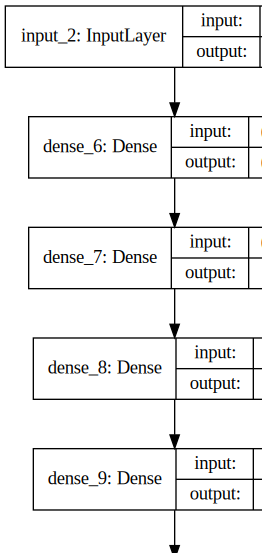

In [8]:
from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
SVG(model_to_dot(autoencoder, \
                 show_shapes=True)
    .create(prog='dot', format='svg'))

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_validation = train_test_split(data_train, test_size=0.2, random_state =123 )
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.fit(x_train, x_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(x_validation, x_validation))

Epoch 1/30
37/37 [==============================] - 0s 5ms/step - loss: 0.0794 - accuracy: 0.2216 - val_loss: 0.0666 - val_accuracy: 0.4780
Epoch 2/30
37/37 [==============================] - 0s 2ms/step - loss: 0.0581 - accuracy: 0.4508 - val_loss: 0.0503 - val_accuracy: 0.4780
Epoch 3/30
37/37 [==============================] - 0s 2ms/step - loss: 0.0454 - accuracy: 0.4508 - val_loss: 0.0409 - val_accuracy: 0.4780
Epoch 4/30
37/37 [==============================] - 0s 2ms/step - loss: 0.0382 - accuracy: 0.4508 - val_loss: 0.0356 - val_accuracy: 0.4780
Epoch 5/30
37/37 [==============================] - 0s 2ms/step - loss: 0.0342 - accuracy: 0.4508 - val_loss: 0.0327 - val_accuracy: 0.4780
Epoch 6/30
37/37 [==============================] - 0s 2ms/step - loss: 0.0320 - accuracy: 0.4508 - val_loss: 0.0310 - val_accuracy: 0.4780
Epoch 7/30
37/37 [==============================] - 0s 2ms/step - loss: 0.0307 - accuracy: 0.4508 - val_loss: 0.0299 - val_accuracy: 0.4780
Epoch 8/30
37/37 [==

In [10]:
predictions = autoencoder.predict(x_test)
mse = np.mean(np.power(x_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,358.000000,358.000000
mean,0.063879,0.491620
std,0.049654,0.500629
min,0.005245,0.000000
25%,0.024942,0.000000
50%,0.050819,0.000000
75%,0.086190,1.000000
max,0.254057,1.000000


In [11]:
error_df[error_df['true_class']==0].describe()

,reconstruction_error,true_class
count,182.000000,182.0
mean,0.029145,0.0
std,0.016729,0.0
min,0.005245,0.0
25%,0.018600,0.0
50%,0.025010,0.0
75%,0.033461,0.0
max,0.112917,0.0


In [12]:
error_df[error_df['true_class']==1].describe()

,reconstruction_error,true_class
count,176.000000,176.0
mean,0.099798,1.0
std,0.046776,0.0
min,0.038972,1.0
25%,0.067916,1.0
50%,0.086066,1.0
75%,0.113759,1.0
max,0.254057,1.0


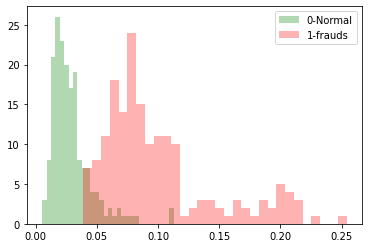

In [13]:
hist_1 = plt.hist(error_df[error_df['true_class']==0].reconstruction_error, bins=30, alpha=0.3,color='green')
hist_2 = plt.hist(error_df[error_df['true_class']==1].reconstruction_error, bins=30, alpha =0.3 ,color='red')
plt.legend(['0-Normal', '1-frauds'], loc ='upper right')
plt.show()

In [14]:
y_true=y_test.values
y_true

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [15]:
mse[mse > 0.037] = 1
mse[mse < 0.037] = 0
mse

array([0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [16]:
#from plot
#threshold 0.037
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred=mse))

              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89       182
         1.0       0.83      1.00      0.90       176

    accuracy                           0.90       358
   macro avg       0.91      0.90      0.90       358
weighted avg       0.91      0.90      0.90       358



In [18]:
bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_11').output)
print(bottleneck_model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                308       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 75        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_10 (Dense)             (None, 14)                84        
_________________________________________________________________
dense_11 (Dense)             (None, 21)               

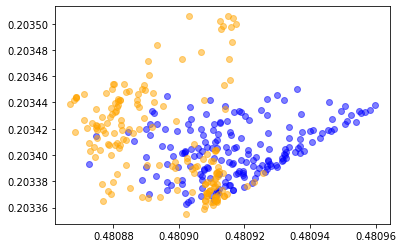

In [19]:
bottleneck_feature_0 = bottleneck_model.predict(test[test['label']==0].drop(['label'], axis=1))
bottleneck_feature_1 = bottleneck_model.predict(test[test['label']==1].drop(['label'], axis=1))
sca_0 = plt.scatter(bottleneck_feature_0[:,0], bottleneck_feature_0[:,1], color= 'blue',alpha=0.5)
sca_1 = plt.scatter(bottleneck_feature_1[:,0], bottleneck_feature_1[:,1], color= 'orange',alpha=0.5)
plt.show()

Analysis:
Describe how you choose the hyperparameters, e.g. dimension of each layer, activation function, loss function etc.
---I try many times with different hyperparameters. In this case, I use (14,5,2) in these three layers. only keeping the encoder and decoder are symmetry, it is ok.
About activation fucntion and loss function,they are normal adjustment parameters.


Discuss whether you are able to detect outliers by reconstruction errors.
---I think this model can work well.

### Task 3:  Anomaly detection by VAE

1. Create a VAE model and complete Requirements (1)-(5) as stated in Task 2.
    - since sampling is used to reconstruct samples, when we reconstruct samples, to reduce the variation in the reconstructed samples, for each sample, we predict many times, i.e. 100 times, and use the mean of predictions as the final output<br><br>
2. Compare the results obtained in both models and comment on pros and cons of each model in following three aspects.
    - Performance:
    - Stability:
    - Robustness:    

In [4]:
class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs

In [12]:

original_dim = 21
intermediate_dim = 14
latent_dim = 2
batch_size = 32
epochs = 30
epsilon_std = 1.0

x = Input(shape=(original_dim,), name='x')
h = Dense(intermediate_dim, activation='relu', 
          name='hidden_enc')(x)
z_mu = Dense(latent_dim, name='mu')(h)
z_log_var = Dense(latent_dim, name='log_var')(h)
z_mu, z_log_var = KLDivergenceLayer(name='kl')([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t), name='sigma')(z_log_var)

eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], 
                                          latent_dim)), name='eps')
z_eps = Multiply(name='z_eps')([z_sigma, eps])
z = Add(name='z')([z_mu, z_eps])

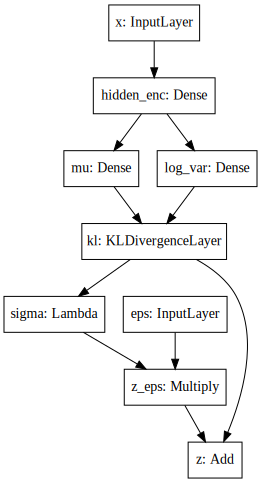

In [6]:
vae_encoder = Model(inputs=[x, eps], outputs=z)
SVG(model_to_dot(vae_encoder, \
                 show_shapes=False, show_layer_names=True)
    .create(prog='dot', format='svg'))

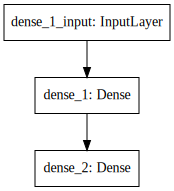

In [7]:
vae_decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x_pred = vae_decoder(z)

SVG(model_to_dot(vae_decoder, \
                 show_shapes=False, show_layer_names=True)
    .create(prog='dot', format='svg'))

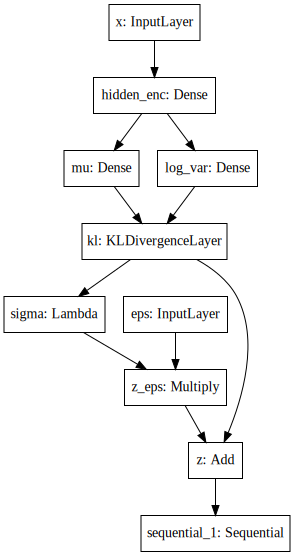

In [8]:
vae = Model(inputs=[x, eps], outputs=x_pred)

SVG(model_to_dot(vae, \
                 show_shapes=False, show_layer_names=True)
    .create(prog='dot', format='svg'))

In [9]:
x_train, x_validation = train_test_split(data_train, test_size=0.2, random_state =123 )
vae.compile(optimizer='rmsprop', loss='mse',metrics=['accuracy'])
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  (None, 21)           0                                            
__________________________________________________________________________________________________
hidden_enc (Dense)              (None, 14)           308         x[0][0]                          
__________________________________________________________________________________________________
mu (Dense)                      (None, 2)            30          hidden_enc[0][0]                 
__________________________________________________________________________________________________
log_var (Dense)                 (None, 2)            30          hidden_enc[0][0]                 
__________________________________________________________________________________________________
kl (KLDiv

In [10]:
x_validation.shape

(295, 21)

In [13]:
hist = vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_validation, x_validation))



Train on 1178 samples, validate on 295 samples
Epoch 1/30
1178/1178 [==============================] - 0s 237us/step - loss: 0.0284 - acc: 0.4508 - val_loss: 0.0280 - val_acc: 0.4780
Epoch 2/30
1178/1178 [==============================] - 0s 130us/step - loss: 0.0284 - acc: 0.4508 - val_loss: 0.0280 - val_acc: 0.4780
Epoch 3/30
1178/1178 [==============================] - 0s 92us/step - loss: 0.0283 - acc: 0.4508 - val_loss: 0.0281 - val_acc: 0.4780
Epoch 4/30
1178/1178 [==============================] - 0s 112us/step - loss: 0.0282 - acc: 0.4508 - val_loss: 0.0280 - val_acc: 0.4780
Epoch 5/30
1178/1178 [==============================] - 0s 99us/step - loss: 0.0283 - acc: 0.4508 - val_loss: 0.0279 - val_acc: 0.4780
Epoch 6/30
1178/1178 [==============================] - 0s 118us/step - loss: 0.0282 - acc: 0.4508 - val_loss: 0.0279 - val_acc: 0.4780
Epoch 7/30
1178/1178 [==============================] - 0s 105us/step - loss: 0.0282 - acc: 0.4508 - val_loss: 0.0278 - val_acc: 0.4780
Epo

In [14]:
predictions_2 = vae.predict(x_test)
mse_2 = np.mean(np.power(x_test - predictions_2, 2), axis=1)
error_df2 = pd.DataFrame({'reconstruction_error': mse_2,
                        'true_class': y_test})
error_df2.describe()


,reconstruction_error,true_class
count,358.000000,358.000000
mean,0.064474,0.491620
std,0.050690,0.500629
min,0.005061,0.000000
25%,0.024763,0.000000
50%,0.050766,0.000000
75%,0.086088,1.000000
max,0.256948,1.000000


In [15]:
error_df2[error_df2['true_class']==0].describe()

,reconstruction_error,true_class
count,182.000000,182.0
mean,0.029128,0.0
std,0.016743,0.0
min,0.005061,0.0
25%,0.018015,0.0
50%,0.024850,0.0
75%,0.033400,0.0
max,0.112889,0.0


In [16]:
error_df2[error_df2['true_class']==1].describe()

,reconstruction_error,true_class
count,176.000000,176.0
mean,0.101024,1.0
std,0.048050,0.0
min,0.039345,1.0
25%,0.067877,1.0
50%,0.086018,1.0
75%,0.113923,1.0
max,0.256948,1.0


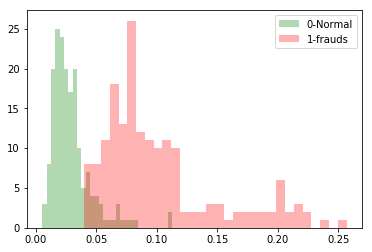

In [17]:
# Construction error plot
hist_3 = plt.hist(error_df2[error_df2['true_class']==0].reconstruction_error, bins=30,alpha=0.3, color='green', label='0-Normal')
hist_4 = plt.hist(error_df2[error_df2['true_class']==1].reconstruction_error, bins=30,alpha =0.3 , color='red',label='1-frauds')
plt.legend()
plt.show()

In [18]:
mse_2[mse_2 > 0.038] = 1
mse_2[mse_2 < 0.038] = 0
mse_2

array([0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [19]:
y_true=y_test.values
y_true

array([0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [20]:
#from plot
#threshold 0.038
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred=mse_2))

             precision    recall  f1-score   support

        0.0       1.00      0.81      0.89       182
        1.0       0.83      1.00      0.91       176

avg / total       0.92      0.90      0.90       358



In [21]:
# deterministic test time encoder
test_encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = test_encoder.predict(x_test, batch_size=batch_size)

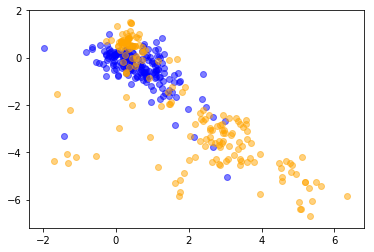

In [22]:
# Latent variable plot
z_test_0 = test_encoder.predict(test[test['label']==0].drop(['label'], axis=1))
z_test_1 = test_encoder.predict(test[test['label']==1].drop(['label'], axis=1))
s_0 = plt.scatter(z_test_0[:,0], z_test_0[:,1], color= 'blue',alpha=0.5, label='0-Normal')
s_1 = plt.scatter(z_test_1[:,0], z_test_1[:,1], color= 'orange',alpha=0.5,label='1-frauds')
plt.show()



Performance: The performance of the two models was similar, with no significant difference
Stability and Robustness:Theoretically, vae model should be better, but perhaps because the sample size is too small for too complex model, so there is no obvious advantage for vae model in this data set